<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.7/7_2_DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [5]:
# for reproducibility
random.seed(999)
torch.manual_seed(999)
if device == 'cuda':
    torch.cuda.manual_seed_all(999)

Parameter 들을 미리 정의

In [ ]:
batch_size = 128

transform=transforms.Compose([transforms.Resize((64,64)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

# root => "../image_data/MNIST/"
dataset = dset.MNIST(root="../image_data/MNIST/", train=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## GAN network

Build Generator

In [ ]:
# Generator Code
# ConvTranspose2(input, output, kernel, stride, padding) 형식

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(25, 1024, 4, 1, 0, bias=False), # from (100,1,1) to (1024,4,4)
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False), # from (1024,4,4) to (512,8,8)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), # from (512,8,8) to (256,16,16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), # from (256,16,16) to (128,32,32))
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False), # from (128,32,32) to (1 x 64 x 64)
            nn.Tanh()) # sigmoid

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator().to(device)

##### Weight Initialize

In [ ]:
# for 가 없어도 m.__class__.__name__ (layer 를 불러오는 것) Command 가
# Generator와 Discriminator 에 있는 layer에 순차적으로 계속 적용되기 때문에 자동으로 for loop 처럼 반복문을 돌리게 된다

# 파이썬 함수중 find 함수를 통해 찾고자 하는 특정 문자열을 입력하면 반환 값으로 그 문자열의 시작위치를 가져 올 수 있다.
# 따라서 ConvTranspose2d 에서의 Conv가 나오는 문자열의 시작위치는 0 이 된다.
# 만약 찾고자 하는 문자열이 없다면 반환값으로 -1을 보낸다.

def weights_init(m):
    layer_name = m.__class__.__name__
    print("여기서 m.__class__.__name__ 은? =>", layer_name)
    
    # layer 에 Conv 라는 글자가 있다면 - (없으면 -1 을 가져오는데 != -1 이므로 '존재한다' 를 의미)
    if layer_name.find('Conv') != -1:
        print("layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉,",  layer_name.find('Conv'))
        print("==================================")
        # 논문에 나온대로 initialize 를 해준다
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    # layer 에 BatchNorm 이라는 글자다 들어간다면
    elif layer_name.find('BatchNorm') != -1:
        print("layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉,",layer_name.find('BatchNorm'))
        # 논문에 나온대로 initialize 를 해준다
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        print("==================================")
        # bias 는 0으로 취해준다
        nn.init.constant_(m.bias.data, 0)
    else:
        print("다른 것들은 그냥 넘어간다")
        print("==================================")
    
    # 이도저도 아니면 아무런 행동을 취하지 않는다 (relu 같은거)

In [ ]:
# Apply the weights_init function(weights to mean=0, stdev=0.2.)
netG.apply(weights_init)

# Print the model
print(netG)

여기서 m.__class__.__name__ 은? => ConvTranspose2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => ReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => ConvTranspose2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => ReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => ConvTranspose2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => ReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => ConvTranspose2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 

Build Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (1,64,64)
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            
            # (128,32,32)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (256,16,16)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (512,8,8)
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (1024,4,4)
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # (100,1,1)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)
    
# Apply the weights_init function(weights to mean=0, stdev=0.2.)
netD.apply(weights_init)

# Print the model
print(netD)

여기서 m.__class__.__name__ 은? => Conv2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => LeakyReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => Conv2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => LeakyReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => Conv2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => LeakyReLU
다른 것들은 그냥 넘어간다
여기서 m.__class__.__name__ 은? => Conv2d
layer_name.find('Conv') 의 결과값은? => Conv 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m.__class__.__name__ 은? => BatchNorm2d
layer_name.find('BatchNorm') 은 그럼 뭐지? => BatchNorm 라는 글자가 나오는 index 를 알려줄 것이다. 즉, 0
여기서 m._

Loss function, Noise (for Generator), Label (for Training), Optimizer

In [ ]:
loss_function = nn.BCELoss()

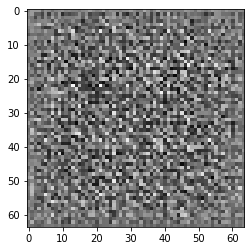

In [ ]:
# Noise 하나를 fix 시켜서 변수에 담아준다. 학습을 하면서 생성되는 image 의 변화를 관찰 할 수 있다
fixed_noise = torch.randn(64, 25, 1, 1).to(device)

plt.imshow(netG(fixed_noise).cpu().detach().numpy()[0].reshape(64,64), cmap="gray")

In [ ]:
# Discriminator 가 real 혹은 false 로 판단할 수 있게끔 scalar 값으로 labeling을 해준다
real_label = 1
fake_label = 0

In [ ]:
# optimizer
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training

In [ ]:
# Training 

num_epochs = 5

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # =================================================================== #
        # (1) Update Discriminator
        # =================================================================== #
        
        ######################################
        # 1. Real Image 로 Discriminator 훈련
        ######################################
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        # label 의 경우 torch 형태로 (1,1,1,1,1,1,1, ... 이 batch size 만큼 들어가있다 (discriminator 와 결과와 비교하기 위해))
        label = torch.full((b_size,), real_label, device=device)
        
        output = netD(real_cpu).view(-1) # .reshape(-1) 을 해주는 이유는 real_tensor 와 shape 를 맞추기 위함
        errD_real = loss_function(output, label)

        errD_real.backward()
        D_x = output.mean().item()  # mini batch 마다 D(x) 의 평균값을 구하기 위함

        ######################################
        # 2. Fake Image 로 Discriminator 훈련
        ######################################
        
        # Generator 에 들어갈 noise 생성
        noise = torch.randn(b_size, 25, 1, 1, device=device)
        
        # Generate 에서 fake image 생성 (Discriminator 가 분간해야 하는 image)
        fake = netG(noise)
        
        # 위에서 미리 만들어둔 label 을 이번에는 0,0,0,0,0,0,...으로 채워준다
        label.fill_(fake_label)
        
        # Noise 를 Discriminator에 넣어보자
        
        output = netD(fake.detach()).view(-1)
        errD_fake = loss_function(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        
        # Update Discriminator
        optimizerD.step()

        # =================================================================== #
        # (2) Update Generator
        # =================================================================== #
        # Generator 는 만들어낸 image 가 discriminator 로 하여금 1 (real) 로 판단 할 수 있게 훈련시켜야 한다
        netG.zero_grad()
        label.fill_(real_label)
        
        # Generator 가 만든 fake_image 를 Discriminator 에 넣어서 학습
        output = netD(fake).view(-1)
        
        errG = loss_function(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()
        
        # Training 경과를 관찰하기 위해 print
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Plotting 을 하기 위해서 list 에 loss 값을 넣어준다
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # 전체 학습횟수 (5 (num_epochs) x 1,200 (minibatch 갯수) = 6,000) 를 하면서 중간중간 generate 된 image 결과값을 저장
        # ((epoch == num_epochs-1) and (batch_size == len(trainloader)-1))
        #   → 가장 마지막 epoch 에서 가장 마지막 minibatch 를 학습할 때의 시점 (맨 마지막 학습 결과)
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise.detach()).cpu()
            img_list.append(vutils.make_grid(fake, normalize=True))
            
        iters += 1

Starting Training Loop...


/opt/conda/conda-bld/pytorch_1591914855613/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/5][0/469]	Loss_D: 1.6540	Loss_G: 19.7424	D(x): 0.8260	D(G(z)): 0.6540 / 0.0000
[0/5][50/469]	Loss_D: 1.8051	Loss_G: 44.2567	D(x): 0.7088	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.4250	Loss_G: 6.0309	D(x): 0.8820	D(G(z)): 0.1801 / 0.0113
[0/5][150/469]	Loss_D: 0.4047	Loss_G: 6.4891	D(x): 0.8324	D(G(z)): 0.0557 / 0.0126
[0/5][200/469]	Loss_D: 0.6583	Loss_G: 1.3459	D(x): 0.7040	D(G(z)): 0.1019 / 0.3754
[0/5][250/469]	Loss_D: 0.3067	Loss_G: 3.3799	D(x): 0.9004	D(G(z)): 0.1569 / 0.0548
[0/5][300/469]	Loss_D: 1.3386	Loss_G: 1.6055	D(x): 0.4028	D(G(z)): 0.0432 / 0.3059
[0/5][350/469]	Loss_D: 0.4194	Loss_G: 2.8254	D(x): 0.9059	D(G(z)): 0.2253 / 0.0942
[0/5][400/469]	Loss_D: 0.8515	Loss_G: 3.2941	D(x): 0.9312	D(G(z)): 0.4702 / 0.0608
[0/5][450/469]	Loss_D: 1.6675	Loss_G: 0.4418	D(x): 0.2883	D(G(z)): 0.0546 / 0.6752
[1/5][0/469]	Loss_D: 0.5007	Loss_G: 2.8032	D(x): 0.8674	D(G(z)): 0.2628 / 0.0785
[1/5][50/469]	Loss_D: 0.6852	Loss_G: 3.8946	D(x): 0.9433	D(G(z)): 0.4195 / 0.0329
[1/5][10

In [ ]:
torch.save(img_list, './torch_save/DC_GAN_MNIST_epoch'+str(num_epochs) +'.pt')

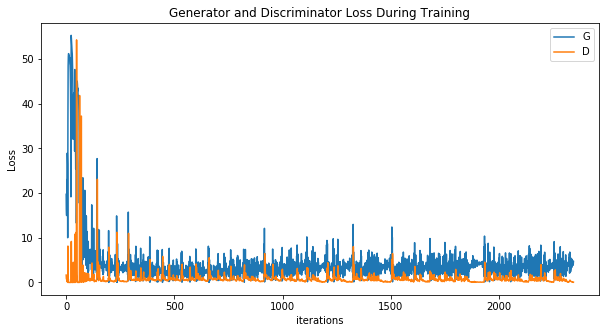

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
sample_image = []
for batch_idx, (image, _) in enumerate(dataloader):
    sample_image.append(image[range(64)]) # 64개의 image
    break

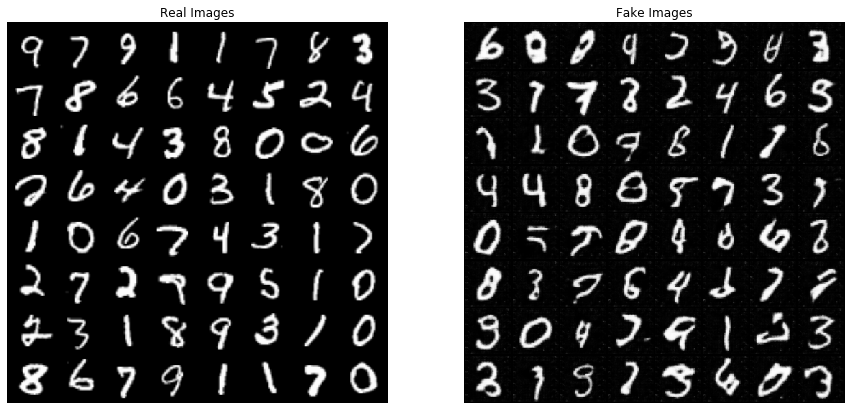

In [ ]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_image[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# 이미지가 깨끗함을 확인 가능함

Save Generator

In [ ]:
torch.save(netG.state_dict(), './pre_trained/DC_GAN_MNIST_epoch'+str(num_epochs) +'.pth')